### Import all required libraries

In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.datasets import make_classification
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorly as tl
from tltorch.factorized_layers import TCL
from sklearn.neural_network import MLPClassifier
from datetime import datetime
import keras
from keras import models, layers
import pandas as pd

## Load the data

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


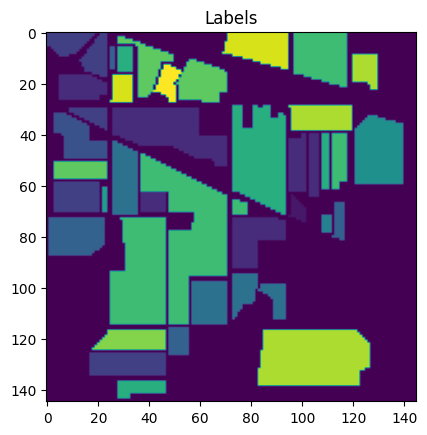

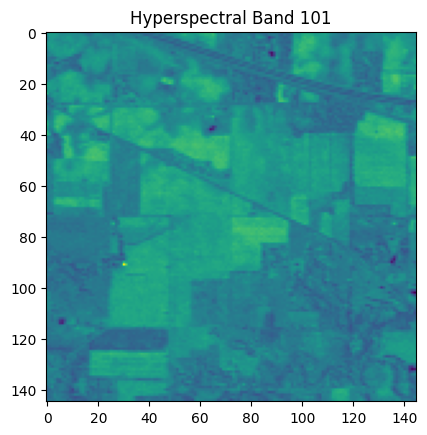

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# list of datasets
gt_files = ['Pavia_gt.mat', 'Botswana_gt.mat', 'Indian_pines_gt.mat', 'KSC_gt.mat', 'Salinas_gt.mat']
data_files = ['Pavia.mat', 'Botswana.mat', 'Indian_pines_corrected.mat', 'KSC.mat', 'Salinas_corrected.mat']
label_files = ['pavia_gt', 'Botswana_gt', 'indian_pines_gt', 'KSC_gt', 'salinas_gt']
hypercube_files = ['pavia', 'Botswana', 'indian_pines_corrected', 'KSC', 'salinas_corrected']

def extract_Features(index):
    # Load the ground truth labels and the hyperspectral data
    gt_file = 'Datasets/' + gt_files[index]
    data_file = 'Datasets/' + data_files[index]

    # TODO: Use if using Colab
    # gt_file = '/content/drive/My Drive/TNN/dataset/' + gt_files[index]
    # data_file = '/content/drive/My Drive/TNN/dataset/' + data_files[index]


    gt = sio.loadmat(gt_file)
    labels = gt[label_files[index]]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files[index]]
    # Scale the data in place and set to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)

    # Show shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    # Visualize the label map and a random band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features(2)

In [3]:
background = np.where(labels==0)
print(background[0].shape)
print(np.unique(labels))
print(5//2)

(10776,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
2


### Extract Windows

In [4]:
def extract_windows(data, labels, window_size):
    """
    Extract patches (windows) from hyperspectral data, corresponding labels, and center coordinates.

    Parameters:
    data: 3D numpy array (H, W, Bands) - the hyperspectral image cube
    labels: 2D numpy array (H, W) - the ground truth labels
    window_size: int - the size of the window to extract around each pixel

    Returns:

    X_windows: List of 3D numpy arrays containing the patches from the hyperspectral image
    y_labels: List of corresponding labels for the center pixel of each window
    coordinates: List of tuples containing (row, col) coordinates of the center pixel
    """
    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []
    y_labels = []
    coordinates = []

    # Loop through each pixel in the original (non-padded) image
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            # Extract the window from the hyperspectral data
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
              X_windows.append(window)
              y_labels.append(label)
              coordinates.append((i-margin, j-margin))  # Store the original coordinates

    return np.array(X_windows), np.array(y_labels), coordinates

# Define window size
window_size = 5

# Extract windows from hyperspectral data, labels, and get coordinates
X_windows, y_labels, coordinates = extract_windows(hypercube, labels, window_size)

# Print the shape of extracted data and some example coordinates
print(f"Extracted windows shape: {X_windows.shape}")
print(f"Corresponding labels shape: {y_labels.shape}")
print(f"Example coordinates: {coordinates[:5]}")


Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)
Example coordinates: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]


### Window Reconstruction

This was done as to ensure that the window extraction properly reflects the original labelled data

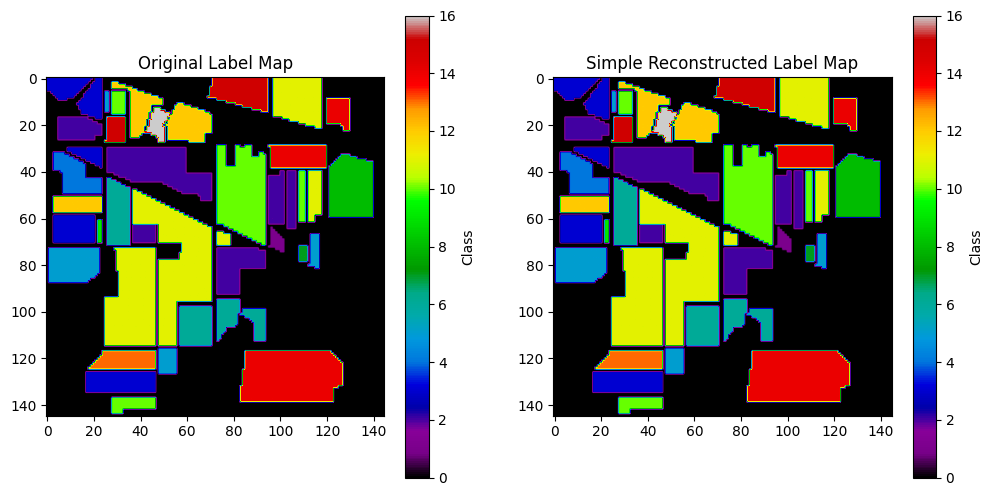

Do the original and reconstructed images match? True


In [5]:
def reconstruct(window_labels, coordinates, original_shape):
    simple_labels = np.zeros(original_shape, dtype=int)

    for idx, (i, j) in enumerate(coordinates):
        simple_labels[i, j] = window_labels[idx]  # Directly assign labels

    return simple_labels

# Run the simple reconstruction
reconstructed_labels = reconstruct(y_labels, coordinates, labels.shape)

# Check if simple reconstruction works
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Original Label Map')
plt.colorbar(label='Class')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_labels, cmap='nipy_spectral')
plt.title('Simple Reconstructed Label Map')
plt.colorbar(label='Class')

plt.show()

# Check if the two arrays match
arrays_match = np.array_equal(labels, reconstructed_labels)

print(f"Do the original and reconstructed images match? {arrays_match}")


### Sample Extraction

In [6]:
# Function that extracts a list of coordinates from the dataset
def get_samples(X_windows, y_labels, samples_per_class):
    # Unique classes in the dataset
    classes = np.unique(y_labels)

    # Containers for storing selected samples
    X_sampled = []
    y_sampled = []
    X_val = []
    y_val = []
    selected_indices_total = []
    validation_selected = []
    validation_total = []

    # Loop over each class and sample `samples_per_class` examples
    for cls in classes:
        # if label = 0, skip
        if cls == 0:
          continue
        # Get the indices for the current class
        class_indices = np.where(y_labels == cls)[0]

        # Shuffle class-specific indices
        np.random.shuffle(class_indices)

        # Select `samples_per_class` samples from this class
        selected_indices = class_indices[:samples_per_class]
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        selected_indices_total.extend(selected_indices)  # Store indices for later
        validation_total.extend(validation_selected)
        # Append the selected samples and their labels
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    # Concatenate the sampled arrays
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)
    y_train = y_train - 1  # Shift labels to start from 0

    # Concatenate the sampled arrays
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1  # Shift labels to start from 0

    # Create the test set from the remaining data (data not selected for training)
    selected_indices_total.extend(validation_total)
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)  # Indices not in training set
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1  # Shift labels to start from 0

    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

### Logistic Regression
#### Train and test the model

In [7]:
# Function to train and test the model, returning accuracy and classification report
def train_and_test_model(X_train, X_test, y_train, y_test):
    # Train the model
    model = LogisticRegression(penalty=None, max_iter=300)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Micro: {f1_score(y_test, y_pred, average='micro'):.2f}")
    print(f"F1 Macro: {f1_score(y_test, y_pred, average='macro'):.2f}")
    print(f"F1 Weighted: {f1_score(y_test, y_pred, average='weighted'):.2f}")

    return accuracy


#### Run the Logistic Regression Model

In [8]:
# Function to compare different numbers of samples per class and evaluate model performance
def Logistic_Regression(X_train, X_test, y_train, y_test):
    # Flatten x_train and x_test
    X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Shape: (148152, 2550)
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)  # Shape: (num_test_samples, 2550)

    print(X_train_flattened.shape)
    print(X_test_flattened.shape)

    # Train and test the model, returning accuracy
    accuracy = train_and_test_model(X_train_flattened, X_test_flattened, y_train, y_test)

    return accuracy


#### Print the results

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
Logistic_Regression(X_train, X_test, y_train, y_test)

print(X_windows.shape)
print(y_labels.shape)

(160, 5000)
(10009, 5000)
Accuracy: 0.44
F1 Micro: 0.44
F1 Macro: 0.46
F1 Weighted: 0.46
(10249, 5, 5, 200)
(10249,)


### FCNN

#### Run FCNN
As an FCNN we are using MLP classifier by sklearn

In [10]:
def Fully_Connected_Neural_Network(X_train, X_test, y_train, y_test):
    results = {}
    #X_flattened = X_windows.reshape(X_windows.shape[0], -1)  # (num_samples, window_size * window_size * num_bands)
    X_train_flattened = X_train.reshape(X_train.shape[0], -1)
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)

    # Initialize the MLPClassifier with 2 hidden layers of default sizes
    model = MLPClassifier(random_state=1, hidden_layer_sizes=(160,256), alpha=0.04, max_iter=350)

    # Fit the model to the training data
    model.fit(X_train_flattened, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_flattened)

    # Calculate test accuracy
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Test Accuracy: {accuracy:.2f}")
    results = accuracy

    return results

### CNN
#### Samples from Classes

In [11]:
def sample_from_classes_cnn(X_train, X_test, y_train, y_test, X_val, y_val):
    classes = np.unique(y_labels)

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_val = np.array(X_val)
    y_val = np.array(y_val)

    # Perform one-hot encoding
    y_train_encoded = keras.utils.to_categorical(y_train, num_classes=len(classes))
    y_test_encoded = keras.utils.to_categorical(y_test, num_classes=len(classes))
    y_val_encoded = keras.utils.to_categorical(y_val, num_classes=len(classes))
    return X_train, X_test, y_train_encoded, y_test_encoded, X_val, y_val_encoded # Return the encoded labels

#### CNN Architecture

In [22]:
# Set up CNN architecture parameters
c_r = 50
# Define the CNN model structure based on Makantasis et al.
def create_cnn(num_classes, shape):
    model = models.Sequential()

    # First Depthwise Separable Conv layer
    #model.add(layers.Conv2D(filters=3 * c_r, kernel_size=(3, 3), activation='sigmoid', padding='valid', input_shape=shape))
    model.add(layers.Conv2D(filters=150, kernel_size=(3, 3), activation='sigmoid', padding='valid', input_shape=shape))
    model.add(layers.BatchNormalization())

    # Second Depthwise Separable Conv layer
    #model.add(layers.Conv2D(filters=3 * (3 * c_r), kernel_size=(3, 3), activation='sigmoid', padding='valid'))
    model.add(layers.Conv2D(filters=300, kernel_size=(3, 3), activation='sigmoid', padding='valid'))
    model.add(layers.BatchNormalization())

    # Flatten the output to transition to Dense layers
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(196, activation='relu')) # 9 * c_r
    #model.add(layers.Dense(6 * c_r, activation='sigmoid'))

    # Output layer with softmax for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))
    print(num_classes)

    return model


#### Run CNN

In [13]:
def Convolutional_Neural_Network(X_train, X_test, y_train, y_test, X_val, y_val, epochs):
    # X_train, X_test, y_train, y_test = sample_from_classes_cnn(X_train, X_test, y_train, y_test)
    shape = X_train[0].shape
    print(shape)

    callback = keras.callbacks.EarlyStopping(
                    monitor="val_acc",
                    min_delta=0,
                    patience=50,
                    verbose=0,
                    mode="max",
                    baseline=None,
                    restore_best_weights=False,
                    start_from_epoch=0,
                )
    # Rebuild and compile model for each sample size
    num_classes = len(np.unique(y_labels))
    #model = create_cnn((num_classes), shape)
    model = create_cnn(num_classes, shape)
    # Compile the model with the new optimizer
    model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])


    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        batch_size=256,
                        callbacks=[callback],
                        verbose=1
                        )
    

    # Evaluate model
    test_loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
    results_test = accuracy

    train_loss, accuracy = model.evaluate(X_train, y_train, verbose=2)
    results_train = accuracy

    return results_test, results_train


#### Test CNN

In [14]:
X_train, X_test, y_train, y_test, X_val, y_val = sample_from_classes_cnn(X_train, X_test, y_train, y_test, X_val, y_val)
results_test, results_train = Convolutional_Neural_Network(X_train, X_test, y_train, y_test, X_val, y_val, 1000)
print(results_test)
print(results_train)

(5, 5, 200)
16


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1000 - loss: 3.1590 - val_accuracy: 0.0625 - val_loss: 2.9263
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4750 - loss: 1.8585 - val_accuracy: 0.0625 - val_loss: 2.9163
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5813 - loss: 1.5507 - val_accuracy: 0.0625 - val_loss: 2.9158
Epoch 4/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7500 - loss: 1.0351 - val_accuracy: 0.0625 - val_loss: 2.9184
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7312 - loss: 0.9992 - val_accuracy: 0.0625 - val_loss: 2.9198
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8062 - loss: 0.8035 - val_accuracy: 0.0625 - val_loss: 2.9197
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7937 - loss: 0.6848 - val_accuracy: 0.0625 - val_loss: 2.9187
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8938 - loss: 0.5685 - val_accuracy: 0.0625 - val_loss: 2.9170
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8813 - loss: 0.5113 - val_accuracy: 0.0625 - val_loss: 2.9175
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9062 - loss: 0.4500 - val_accuracy: 0.0625 - val_loss: 2.9193
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9250 - loss: 0.3853 - val_accuracy: 0.0625 - val_loss: 2.

### TNN

In [15]:
# TODO: Use if using Colab
# !pip install tensorly tensorly-torch

#### TNN Architecture

In [16]:
tl.set_backend('pytorch')

class TensorNet(nn.Module):
    def __init__(self, input_shape, num_of_classes):
        super(TensorNet, self).__init__()
        self.tcl1 = TCL(input_shape=input_shape, rank=(256, 5, 5))
        self.tcl1.reset_parameters()
        self.bn1 = nn.BatchNorm2d(256)
        self.tcl2 = TCL(input_shape=(256, 5, 5), rank=(256, 3, 3))
        self.tcl2.reset_parameters()
        self.bn2 = nn.BatchNorm2d(256)
        self.tcl3 = TCL(input_shape=(256, 3, 3), rank=(128, 3, 3))
        self.tcl3.reset_parameters()
        self.bn3 = nn.BatchNorm2d(128)
        self.tcl4 = TCL(input_shape=(128, 3, 3), rank=(128, 1, 1))
        self.tcl4.reset_parameters()
        self.bn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 1 * 1, 64)
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        self.bn5 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, num_of_classes)


    def forward(self, x):
        x = F.relu(self.bn1(self.tcl1(x)))
        x = F.relu(self.bn2(self.tcl2(x)))
        x = F.relu(self.bn3(self.tcl3(x)))
        x = F.relu(self.bn4(self.tcl4(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.sigmoid(self.bn5(self.fc1(x)))
        x = self.fc2(x)
        return x

In [45]:
import torch
from torch import nn

model = TensorNet(input_shape=(176, 5, 5), num_of_classes=13)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 170613


#### Run TNN

In [17]:
def Tensor_Neural_Network(X_train, X_test, X_val, y_train, y_test, y_val, num_of_classes, epochs, patience=100):

    X_train = np.moveaxis(X_train, 3, 1)
    X_test = np.moveaxis(X_test, 3, 1)
    X_val = np.moveaxis(X_val, 3, 1)

    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
    test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

    trainloader = DataLoader(train_dataset, shuffle=True, batch_size=256)
    valloader = DataLoader(val_dataset, shuffle=False, batch_size=256)
    testloader = DataLoader(test_dataset, shuffle=False, batch_size=256)

    model = TensorNet(X_train[0].shape, num_of_classes=num_of_classes)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = 999
    patience_counter = 0
    best_model_state = None
    
    # Training loop with validation
    for epoch in range(epochs + 1):
        model.train()
        total_loss = 0
        for windows, labels in trainloader:
            predictions = model(windows)
            loss = criterion(predictions, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Compute validation accuracy
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for windows, labels in valloader:
                predictions = model(windows)
                loss = criterion(predictions, labels)
                val_loss += loss.item()

        val_loss /= len(valloader)

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {total_loss/len(trainloader):.4f}, Val Loss: {val_loss:.4f}')

        # Check if the current model is the best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()  # Save the best model state
            patience_counter = 0  # Reset counter if loss improves
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}, best val loss: {best_val_loss:.4f}")
            break

    # Load the best model before testing
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Final test accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for windows, labels in testloader:
            predictions = model(windows)
            _, predicted = torch.max(predictions.data, 1)
            _, ground_truth = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == ground_truth).sum().item()

    accuracy_test = correct / total
    print(f'Test Accuracy: {100 * accuracy_test:.2f}%')

    # Train accuracy computation
    correct = 0
    total = 0
    with torch.no_grad():
        for windows, labels in trainloader:
            predictions = model(windows)
            _, predicted = torch.max(predictions.data, 1)
            _, ground_truth = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == ground_truth).sum().item()

    accuracy_train = correct / total
    print(f'Train Accuracy: {100 * accuracy_train:.2f}%')

    return accuracy_test


#### Test TNN

In [18]:
tnn_test = Tensor_Neural_Network(X_train, X_test, X_val, y_train, y_test, y_val, 16, 1500)
print(tnn_test)

Epoch [0/1500], Loss: 2.7991, Val Loss: 2.8045
Epoch [10/1500], Loss: 2.3016, Val Loss: 2.7836
Epoch [20/1500], Loss: 2.0638, Val Loss: 2.7817
Epoch [30/1500], Loss: 1.8738, Val Loss: 2.7841
Epoch [40/1500], Loss: 1.6994, Val Loss: 2.7867
Epoch [50/1500], Loss: 1.5264, Val Loss: 2.7830
Epoch [60/1500], Loss: 1.3632, Val Loss: 2.7477
Epoch [70/1500], Loss: 1.2172, Val Loss: 2.5807
Epoch [80/1500], Loss: 1.0889, Val Loss: 2.3301
Epoch [90/1500], Loss: 0.9686, Val Loss: 2.0369
Epoch [100/1500], Loss: 0.8606, Val Loss: 1.8325
Epoch [110/1500], Loss: 0.7629, Val Loss: 1.7093
Epoch [120/1500], Loss: 0.6798, Val Loss: 1.6933
Epoch [130/1500], Loss: 0.6001, Val Loss: 1.5823
Epoch [140/1500], Loss: 0.5310, Val Loss: 1.5465
Epoch [150/1500], Loss: 0.4708, Val Loss: 1.5232
Epoch [160/1500], Loss: 0.4186, Val Loss: 1.4817
Epoch [170/1500], Loss: 0.3732, Val Loss: 1.4480
Epoch [180/1500], Loss: 0.3340, Val Loss: 1.4304
Epoch [190/1500], Loss: 0.2999, Val Loss: 1.4085
Epoch [200/1500], Loss: 0.2703,

KeyboardInterrupt: 

### Run all classifiers

This code runs all the classifiers 10 times, then storing the values withing the results excel files

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


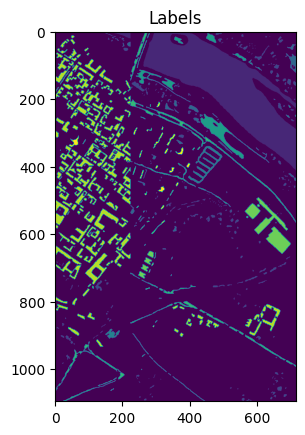

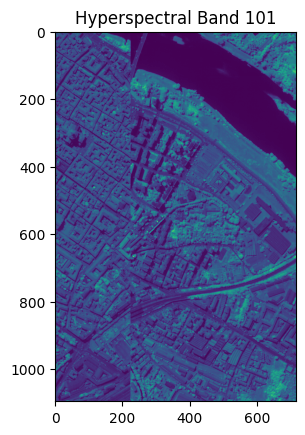

(45, 2550)
(148062, 2550)
Accuracy: 0.89
F1 Micro: 0.89
F1 Macro: 0.74
F1 Weighted: 0.90


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.89
(5, 5, 102)


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9
Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1111 - loss: 2.3359 - val_accuracy: 0.1111 - val_loss: 2.2455
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5556 - loss: 0.9902 - val_accuracy: 0.1111 - val_loss: 2.2290
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6222 - loss: 1.2739 - val_accuracy: 0.1111 - val_loss: 2.2147
Epoch 4/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8000 - loss: 0.5954 - val_accuracy: 0.1111 - val_loss: 2.2021
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8000 - loss: 0.6495 - val_accuracy: 0.1111 - val_loss: 2.1899
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8889 - loss: 0.4385 - val_accuracy: 0.1111 - val_loss: 2.1782
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8889 - loss: 0.3316 - val_accuracy: 0.1333 - val_loss: 2.1671
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8889 - loss: 0.3315 - val_accuracy: 0.1333 - val_loss: 2.1559
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9556 - loss: 0.2655 - val_accuracy: 0.1556 - val_loss: 2.1449
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9778 - loss: 0.2212 - val_accuracy: 0.1556 - val_loss: 2.1351
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9556 - loss: 0.2102 - val_accuracy: 0.1556 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.95
(5, 5, 102)
9
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 2.9722 - val_accuracy: 0.1111 - val_loss: 2.3242
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4444 - loss: 1.5214 - val_accuracy: 0.1111 - val_loss: 2.2889
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4889 - loss: 1.2247 - val_accuracy: 0.1111 - val_loss: 2.2654
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6333 - loss: 0.9538

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6333 - loss: 0.9538 - val_accuracy: 0.1111 - val_loss: 2.2495
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6778 - loss: 0.7577 - val_accuracy: 0.1111 - val_loss: 2.2241
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7889 - loss: 0.6400 - val_accuracy: 0.1111 - val_loss: 2.1983
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8667 - loss: 0.5282 - val_accuracy: 0.1778 - val_loss: 2.1789
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8667 - loss: 0.4850 - val_accuracy: 0.2222 - val_loss: 2.1647
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8889 - loss: 0.4463 - val_accuracy: 0.2222 - val_loss: 2.1526
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9000 - loss: 0.3731 - val_accuracy: 0.2222 - val_loss: 2.1423
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9333 - loss: 0.3575 - val_accuracy: 0.2222 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0533 - loss: 2.6046 - val_accuracy: 0.1111 - val_loss: 2.2797
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5200 - loss: 1.6744 - val_accuracy: 0.1111 - val_loss: 2.2617
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5467 - loss: 1.4137 - val_accuracy: 0.1111 - val_loss: 2.2448
Epoch 4/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6978 - loss: 0.7444 - val_accuracy: 0.1111 - val_loss: 2.2290
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6711 - loss: 0.7682 - val_accuracy: 0.1111 - val_loss: 2.2120
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7467 - loss: 0.5835 - val_accuracy: 0.1111 - val_loss: 2.1976
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8889 - loss: 0.4605 - val_accuracy: 0.1111 - val_loss: 2.1859
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8578 - loss: 0.4640 - val_accuracy: 0.1111 - val_loss: 2.1763
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8978 - loss: 0.4018 - val_accuracy: 0.1333 - val_loss: 2.1683
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9067 - loss: 0.3514 - val_accuracy: 0.1333 - val_loss: 2.1595
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9067 - loss: 0.3295 - val_accuracy: 0.1778 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.1089 - loss: 2.7412 - val_accuracy: 0.1111 - val_loss: 2.2422
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6159 - loss: 1.2514 - val_accuracy: 0.1111 - val_loss: 2.2334
Epoch 3/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6992 - loss: 0.6843

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7012 - loss: 0.6691 - val_accuracy: 0.1111 - val_loss: 2.2403
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8237 - loss: 0.5421 - val_accuracy: 0.1111 - val_loss: 2.2461
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8696 - loss: 0.4521 - val_accuracy: 0.1111 - val_loss: 2.2535
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8618 - loss: 0.4192 - val_accuracy: 0.1111 - val_loss: 2.2607
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9063 - loss: 0.3491 - val_accuracy: 0.1111 - val_loss: 2.2680
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8908 - loss: 0.3335 - val_accuracy: 0.1111 - val_loss: 2.2708
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8995 - loss: 0.3101 - val_accuracy: 0.1111 - val_loss: 2.2745
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9197 - loss: 0.2827 - val_accuracy: 0.1111 - val_loss: 2.2

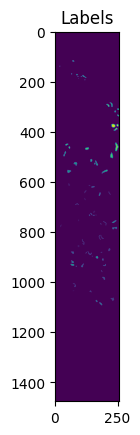

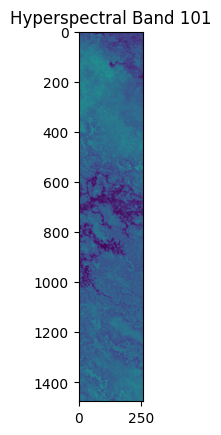

(70, 3625)
(3108, 3625)
Accuracy: 0.76
F1 Micro: 0.76
F1 Macro: 0.78
F1 Weighted: 0.76
Test Accuracy: 0.90
(5, 5, 145)
14
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0143 - loss: 2.7854 - val_accuracy: 0.0714 - val_loss: 2.8575
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2571 - loss: 2.1481 - val_accuracy: 0.0714 - val_loss: 2.8412
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3143 - loss: 1.8284 - val_accuracy: 0.0714 - val_loss: 2.8305
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5714 - loss: 1.3278

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5714 - loss: 1.3278 - val_accuracy: 0.0714 - val_loss: 2.8218
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5857 - loss: 1.2195 - val_accuracy: 0.0714 - val_loss: 2.8141
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7143 - loss: 1.0365 - val_accuracy: 0.0714 - val_loss: 2.8072
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8000 - loss: 0.8846 - val_accuracy: 0.0714 - val_loss: 2.8007
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8143 - loss: 0.7763 - val_accuracy: 0.0714 - val_loss: 2.7953
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8857 - loss: 0.6669 - val_accuracy: 0.0714 - val_loss: 2.7916
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9571 - loss: 0.5866 - val_accuracy: 0.0714 - val_loss: 2.7882
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9571 - loss: 0.5128 - val_accuracy: 0.0714 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0357 - loss: 2.8635 - val_accuracy: 0.0714 - val_loss: 2.7148
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3500 - loss: 1.7563 - val_accuracy: 0.0714 - val_loss: 2.7084
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4071 - loss: 1.4664 - val_accuracy: 0.0714 - val_loss: 2.7041
Epoch 4/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5429 - loss: 1.2528 - val_accuracy: 0.0714 - val_loss: 2.7037
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6429 - loss: 1.0590 - val_accuracy: 0.0714 - val_loss: 2.7043
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7500 - loss: 0.8962 - val_accuracy: 0.0714 - val_loss: 2.7066
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8214 - loss: 0.8012 - val_accuracy: 0.0714 - val_loss: 2.7095
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8643 - loss: 0.6985 - val_accuracy: 0.0714 - val_loss: 2.7129
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8714 - loss: 0.6038 - val_accuracy: 0.0714 - val_loss: 2.7166
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8786 - loss: 0.5409 - val_accuracy: 0.0714 - val_loss: 2.7202
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9143 - loss: 0.4780 - val_accuracy: 0.1286 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.1407 - loss: 2.6809 - val_accuracy: 0.0714 - val_loss: 2.8223
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3758 - loss: 2.0934 - val_accuracy: 0.0714 - val_loss: 2.8262
Epoch 3/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5547 - loss: 1.5291

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5411 - loss: 1.4951 - val_accuracy: 0.0714 - val_loss: 2.8151
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6735 - loss: 1.1109 - val_accuracy: 0.0714 - val_loss: 2.8069
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6838 - loss: 0.9237 - val_accuracy: 0.0714 - val_loss: 2.7973
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7418 - loss: 0.7970 - val_accuracy: 0.0714 - val_loss: 2.7908
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8093 - loss: 0.6610 - val_accuracy: 0.0714 - val_loss: 2.7870
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8725 - loss: 0.5461 - val_accuracy: 0.0714 - val_loss: 2.7823
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9091 - loss: 0.4504 - val_accuracy: 0.0714 - val_loss: 2.7788
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9040 - loss: 0.3895 - val_accuracy: 0.0714 - val_loss: 2.7

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.1327 - loss: 2.4078 - val_accuracy: 0.0714 - val_loss: 2.8597
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4744 - loss: 1.4443 - val_accuracy: 0.0714 - val_loss: 2.8451
Epoch 3/1000
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6133 - loss: 1.0246

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6569 - loss: 0.9858 - val_accuracy: 0.0714 - val_loss: 2.8347
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7539 - loss: 0.7725 - val_accuracy: 0.0714 - val_loss: 2.8235
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8091 - loss: 0.6347 - val_accuracy: 0.1429 - val_loss: 2.8163
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8617 - loss: 0.5064 - val_accuracy: 0.1429 - val_loss: 2.8128
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8947 - loss: 0.4057 - val_accuracy: 0.1429 - val_loss: 2.8130
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9222 - loss: 0.3267 - val_accuracy: 0.1429 - val_loss: 2.8092
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8989 - loss: 0.3324 - val_accuracy: 0.0714 - val_loss: 2.8140
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9387 - loss: 0.2562 - val_accuracy: 0.0714 - val_loss: 2.8

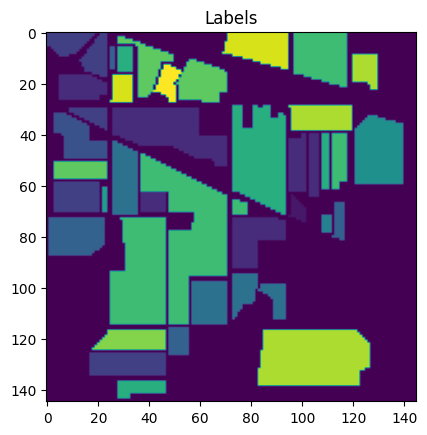

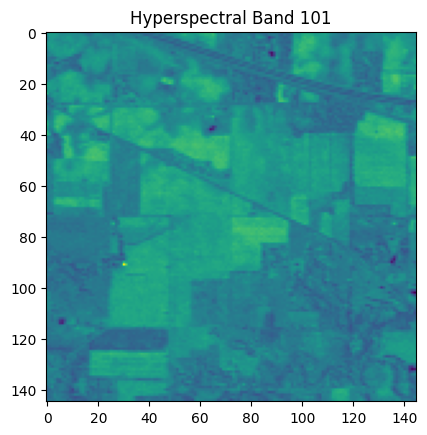

(80, 5000)
(10089, 5000)
Accuracy: 0.47
F1 Micro: 0.47
F1 Macro: 0.46
F1 Weighted: 0.47


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.50
(5, 5, 200)
16
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0875 - loss: 3.0323 - val_accuracy: 0.0625 - val_loss: 2.8922
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5125 - loss: 1.7344 - val_accuracy: 0.0625 - val_loss: 2.8836
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5875 - loss: 1.4847 - val_accuracy: 0.0625 - val_loss: 2.8806
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8375 - loss: 0.9429

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8375 - loss: 0.9429 - val_accuracy: 0.0625 - val_loss: 2.8822
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8375 - loss: 0.8267 - val_accuracy: 0.0625 - val_loss: 2.8851
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9000 - loss: 0.6441 - val_accuracy: 0.0625 - val_loss: 2.8937
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9500 - loss: 0.4599 - val_accuracy: 0.0625 - val_loss: 2.9057
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9250 - loss: 0.4209 - val_accuracy: 0.0625 - val_loss: 2.9167
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9500 - loss: 0.3143 - val_accuracy: 0.0625 - val_loss: 2.9261
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9375 - loss: 0.2732 - val_accuracy: 0.0625 - val_loss: 2.9347
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9625 - loss: 0.2180 - val_accuracy: 0.0625 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.46
(5, 5, 200)
16
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0250 - loss: 3.5136 - val_accuracy: 0.0625 - val_loss: 2.8510
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3000 - loss: 2.1590 - val_accuracy: 0.0625 - val_loss: 2.8399
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4750 - loss: 1.6380 - val_accuracy: 0.0625 - val_loss: 2.8323
Epoch 4/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5437 - loss: 1.4036 - val_accuracy: 0.0875 - val_loss: 2.8268
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7563 - loss: 1.0952 - val_accuracy: 0.0625 - val_loss: 2.8224
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7625 - loss: 0.9798 - val_accuracy: 0.0625 - val_loss: 2.8216
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8000 - loss: 0.8126 - val_accuracy: 0.0625 - val_loss: 2.8236
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8188 - loss: 0.7636 - val_accuracy: 0.0625 - val_loss: 2.8247
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8875 - loss: 0.6250 - val_accuracy: 0.0625 - val_loss: 2.8254
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8750 - loss: 0.5587 - val_accuracy: 0.0625 - val_loss: 2.8270
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9062 - loss: 0.4789 - val_accuracy: 0.0625 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: Undefin

Accuracy: 0.61
F1 Micro: 0.61
F1 Macro: 0.56
F1 Weighted: 0.62
Test Accuracy: 0.48
(5, 5, 200)
16
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Generate a timestamp once
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f"results/results_{timestamp}.xlsx"

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for run_idx in range(10):
        sample_sizes = [5, 10, 25, 50]
        results = []
        time_results = []

        for i in range(10):
            hypercube, labels = extract_Features(i)
            dataset_name = hypercube_files[i]

            X_windows, y_labels, coordinates = extract_windows(hypercube, labels, window_size)
            num_of_classes = len(np.unique(y_labels))

            for idx, samples in enumerate(sample_sizes):
                X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, samples)

                # Measure and store LR time
                LR_result = Logistic_Regression(X_train, X_test, y_train, y_test)

                # Measure and store MLP time
                MLP_result = Fully_Connected_Neural_Network(X_train, X_test, y_train, y_test)

                X_train, X_test, y_train, y_test, X_val, y_val = sample_from_classes_cnn(X_train, X_test, y_train, y_test, X_val, y_val)

                # Measure CNN
                cnn_test, cnn_train = Convolutional_Neural_Network(X_train, X_test, y_train, y_test, X_val, y_val, 1000)

                # Measure TNN
                tnn_test = Tensor_Neural_Network(X_train, X_test, X_val, y_train, y_test, y_val, num_of_classes, 1500)

                # Append results
                results.append([
                    dataset_name if idx == 0 else np.nan,
                    samples,
                    LR_result,
                    MLP_result,
                    cnn_test,
                    tnn_test
                ])

        df = pd.DataFrame(results, columns=['Dataset', 'Samples', 'LR', 'MLP', 'CNN', 'TNN'])

        df.to_excel(writer, sheet_name=f"Run {run_idx + 1}", index=False)

print(f"All results saved to {output_file}")

In [ ]:
import os
os.system("rundll32.exe powrprof.dll,SetSuspendState 0,1,0")

0